In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
FORECAST = 5
LAG = 12
EPS = 120
DEEP = False
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
dset = SingleStop(SROUTE, 30, 'train', 32, lag=LAG).generator()
evalset = SingleStop(SROUTE, 30, 'test', 32, lag=LAG).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.85s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
 [*] Subset in Stop-30: 6079
Locals dataset: test
 [*] Loaded routes: 1 (0.36s)
 [*] Has trainable inds: 262262
 [*] Subset test: 50156
 [*] Subset in Stop-30: 1549


In [5]:
from models.temporal.Cast import Cast

In [6]:
model = Cast(forecast=FORECAST, hidden_size=256, deep=DEEP, lag=LAG).to(device)
model.device = device

In [7]:
criterion, opt, sch = model.params(lr=0.001)

In [8]:
evaluate(evalset, model, criterion)

Eval loss: 20.54947942616988


In [9]:
losses = []
eval_losses = []
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_losses.append(evaluate(evalset, model, criterion, result=True))
#     torch.save(model.state_dict(), 'checkpoints/%s_e%d.pth' % (model.name, eii+1))
    sys.stdout.flush()
    sch.step()

[1/120 : 190/190] - L1.37        
Eval loss: 4.939166516673808
[2/120 : 190/190] - L2.74        
Eval loss: 4.168703230059877
[3/120 : 190/190] - L2.00        
Eval loss: 3.794444063488318
[4/120 : 190/190] - L0.96        
Eval loss: 3.4597205258145625
[5/120 : 190/190] - L0.61        
Eval loss: 3.1940634493925133
[6/120 : 190/190] - L0.98        
Eval loss: 2.9624854089046013
[7/120 : 190/190] - L0.30        
Eval loss: 2.766936329858644
[8/120 : 190/190] - L1.32        
Eval loss: 2.671200437813389
[9/120 : 190/190] - L0.34        
Eval loss: 2.520817077585629
[10/120 : 190/190] - L0.93       
Eval loss: 2.3357789482997386
[11/120 : 190/190] - L1.80        
Eval loss: 2.2935926902050876
[12/120 : 190/190] - L0.08        
Eval loss: 2.157067210394509
[13/120 : 190/190] - L0.10        
Eval loss: 2.072653636640432
[14/120 : 190/190] - L0.07       
Eval loss: 1.9724841569455303
[15/120 : 190/190] - L0.23        
Eval loss: 1.9382883360495373
[16/120 : 190/190] - L0.42        
Eval loss

Process Process-991:
Process Process-993:
Process Process-992:
Process Process-994:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_IN

KeyboardInterrupt: 

In [10]:
# torch.save(model.state_dict(), 'checkpoints/tmp_spot_rnn_short.pth')

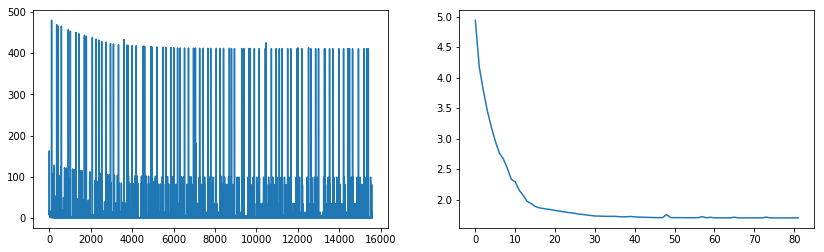

In [11]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.subplot(1, 2, 2)
plt.plot(eval_losses)
plt.show();plt.close()

4


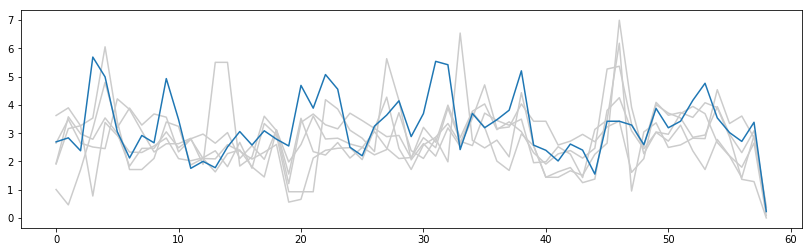

In [12]:
data = history_byname(SROUTE)

sample = data[int(TSTEPS*0.8):]
inds, integs = high_integ(sample[LAG:])
inds += LAG
# print(inds[0])
sample = sample[inds[0]-LAG:inds[0]]
# sample = hist_smooth(sample)
print(np.count_nonzero(np.isnan(sample)))
for jj, ii in zip(*np.where(np.isnan(sample))):
    sample[jj, ii] = sample[jj-1, ii]
show_context(sample)

In [15]:
preds = []
bi = 30
hist = torch.Tensor(np.expand_dims(sample[:, bi-10:bi], 0))
Xs, _ = model.format_batch(hist)
yout = tonpy(model(Xs))
#     preds.append(tonpy(yout))

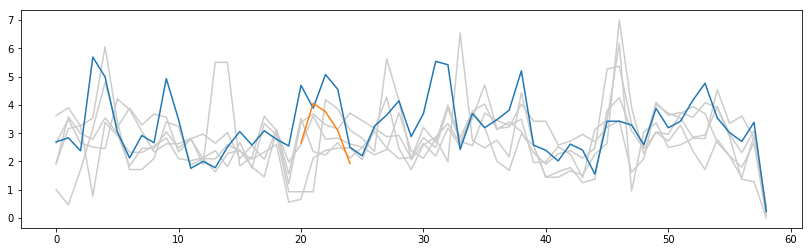

In [16]:
show_context(sample, draw=False)
# for bi in range(10, sample.shape[1]+1, 5):
ylast = np.flip(yout[0, :])
xpos = list(range(bi-10, bi-5))
plt.plot(xpos, ylast, color='C1')
plt.show(); plt.close()